# Black-Box Uncertainty Quantification Demo

Content
1. [Introduction](#section1')
2. [Set up LLM and Prompts](#section2')
3. [Generate Responses and Confidence Scores](#section3')<br>
4. [Performance Evaluation](#section4')

In [6]:
import warnings

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner
from uqlm.quantifiers import BlackBoxUQ

warnings.filterwarnings("ignore")

<a id='section1'></a>
## 1. Introduction

Black-box Uncertainty Quantification (UQ) methods treat the LLM as a black box and evaluate response consistency to estimate response-level confidence. This demo provides an illustration of how to use state-of-the-art black-box UQ methods with `uqlm`.

**Pros:**

*   ✅  **Universal Compatibility:** Works with any LLM.
*   ✅  **Intuitive:** Easy to understand and implement.
*   ✅  **No Internal Access Required:** Doesn't need token probabilities or model internals.

**Cons:**

*   ⚠️  **Higher Cost:** Requires multiple generations per prompt.
*   ⚠️  **Slower:**  Multiple generations and comparison calculations increase latency.

**Available Scorers:**

*   Contradiction Probability ([Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175); [Lin et al., 2025](https://arxiv.org/abs/2305.19187); [Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Semantic Entropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0); [Kuh et al., 2023](https://arxiv.org/pdf/2302.09664))
*   Exact Match ([Cole et al., 2023](https://arxiv.org/abs/2305.14613); [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175))
*   BERT-score ([Manakul et al., 2023](https://arxiv.org/abs/2303.08896); [Zheng et al., 2020](https://arxiv.org/abs/1904.09675))
*   BLUERT-score ([Sellam et al., 2020](https://arxiv.org/abs/2004.04696))
*   Cosine Similarity ([Shorinwa et al., 2024](https://arxiv.org/pdf/2412.05563); [HuggingFace](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2))

<a id='section2'></a>
## 2. Set up LLM and Prompts

In [9]:
# Load example dataset (SVAMP)
svamp = (
    load_example_dataset("svamp")
    .rename(columns={"question_concat": "question", "Answer": "answer"})[
        ["question", "answer"]
    ]
    .head(75)
)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [11]:
# Define prompts
MATH_INSTRUCTION = (
    "When you solve this math problem only return the answer with no additional text.\n"
)
prompts = [MATH_INSTRUCTION + prompt for prompt in svamp.question]

In [13]:
# Instantiate BaseChatModel
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-pro")

Note that although we use `ChatVertexAI` in this example, any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used.

<a id='section3'></a>
## 3. Generate responses and confidence scores

#### `BlackBoxUQ()` - Class for computing token probability-based confidence scores on LLM responses for the provided prompts (hallucination detection).

**Class Attributes:**
- `llm` (**BaseChatModel, default=None**) A langchain llm (`BaseChatModel`). User is responsible for specifying temperature and other relevant parameters to the constructor of their `BaseChatModel` object.
- `nli_scorer` - (**class_object, default=None**) A class object to compute the semantic similarity score using a natural language inference model. This object must have a `predict` method, which returns probability of contradiction for provided input. Default case, uses DeBERTA model trained on MNLI dataset.
- `device` - (**str or torch.device input or torch.device object, default="cpu"**) Specifies the device that classifiers use for prediction. Set to "cuda" for classifiers to be able to leverage the GPU.
- `system_prompt` - (**str or None, default="You are a helpful assistant."**) Optional argument for user to provide custom system prompt
- `max_calls_per_min` - (**int, default=None**) Specifies how many api calls to make per minute to avoid a rate limit error. By default, no limit is specified.
- `use_n_param` (**bool, default=False**) Specifies whether to use `n` parameter for `BaseChatModel`. Not compatible with all `BaseChatModel` classes. If used, it speeds up the generation process substantially when `num_responses` is large.
- `postprocessor` - (**f(str) -> str, default=None**) A user-defined function to postprocess responses.
- `scorers` - (**subset of {'entropy_score', 'noncontradiction_score', 'match_score', 'bert_score', 'bleurt_score', 'cosine_score'}, default=None**) Specifies which black box (consistency) scorers to include. If None, defaults to ["entropy_score", "noncontradiction_score", "match_score", "cosine_score"]   

**Class Methods:**
1. `evaluate` - Generate responses and compute black-box (consistency-based) confidence scores on LLM responses for the provided prompts.

    **Method Attributes:**
    - `prompts` - (**list of str**) A list of input prompts for the model.
    - `responses` - (**list of str, default=None**) A list of model responses for the prompts. If not provided, this method will generate responses for `self.llm`. 
    - `multiple_responses` - (**list of list of str, default=None**) A list of multiple model responses, each element (multiple_responses[i]) is a list of str, containing multiple model responses for prompts[i]. If not provided, this method will generate responses for `self.llm`.
    - `mr_temperature` - (**float, default=1**) The `temperature` parameter for llm model to generate multiple responses
    - `num_responses` - (**int, default=5**) The number of multiple responses used to compute observed consistency.
    
    **Returns:**
        `UQResult` containing data (prompts, responses, and confidence scores) and metadata 

In [15]:
import torch

device = torch.device("cuda")  # use if GPU available
# device = None

In [17]:
bbuq = BlackBoxUQ(
    llm=llm,
    max_calls_per_min=250,
    device=device,
    system_prompt=MATH_INSTRUCTION,
    scorers=["entropy_score", "match_score", "cosine_score"],
)

I0000 00:00:1741803952.647070   33403 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical 

In [19]:
results = await bbuq.evaluate(
    prompts=prompts,
    num_responses=10,
    # responses=responses # provide if responses already generated
    # multiple_responses=multiple_responses # provide if candidate responses already generated
)

Generating responses...
Generating candidate responses...
Computing confidence scores...


In [20]:
result_df = results.to_df()
result_df.head(5)

,prompt,response,multiple_responses,match_score,cosine_score,entropy_score
0,When you solve this math problem only return t...,145,"[145, 145, 145, 145, 145, 3, 145, 145, 145, 145]",0.9,0.972187,0.867698
1,When you solve this math problem only return t...,19,"[ 19 pounds., 19 pounds., 19 pounds , 19, 19, ...",0.5,0.920831,0.424396
2,When you solve this math problem only return t...,$3,"[$3.00, $3, $4, 2\n, 3, $3.00, 2, $ 3, $3.00\n...",0.1,0.853195,0.316378
3,When you solve this math problem only return t...,198,"[198., 198, 198, 198, 198, 198, 198, 198, 198,...",0.9,0.998001,0.867698
4,When you solve this math problem only return t...,63,"[63, 63, 63, 63, 63, 63 dollars, 63 dollars, 6...",0.8,0.971171,1.000000


<a id='section4'></a>
## 4. Evaluate performance

In [21]:
# Populate correct answers and grade responses
result_df["answer"] = svamp.answer
result_df["response_correct"] = [
    math_postprocessor(r) == a for r, a in zip(result_df["response"], svamp["answer"])
]
result_df.head(5)

,prompt,response,multiple_responses,match_score,cosine_score,entropy_score,answer,response_correct
0,When you solve this math problem only return t...,145,"[145, 145, 145, 145, 145, 3, 145, 145, 145, 145]",0.9,0.972187,0.867698,145,True
1,When you solve this math problem only return t...,19,"[ 19 pounds., 19 pounds., 19 pounds , 19, 19, ...",0.5,0.920831,0.424396,19,True
2,When you solve this math problem only return t...,$3,"[$3.00, $3, $4, 2\n, 3, $3.00, 2, $ 3, $3.00\n...",0.1,0.853195,0.316378,3,True
3,When you solve this math problem only return t...,198,"[198., 198, 198, 198, 198, 198, 198, 198, 198,...",0.9,0.998001,0.867698,198,True
4,When you solve this math problem only return t...,63,"[63, 63, 63, 63, 63, 63 dollars, 63 dollars, 6...",0.8,0.971171,1.000000,63,True


In [22]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.7333333333333333


Next we will plot filtered LLM accuracy at various confidence score thresholds. The idea is to measure the LLM's performance when we consider responses with confidence scores above a given threshold.

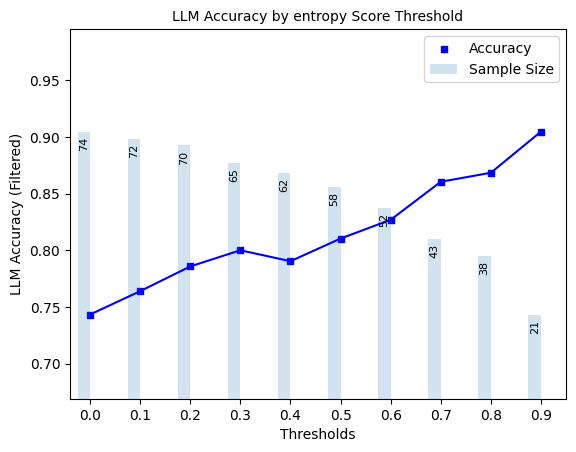

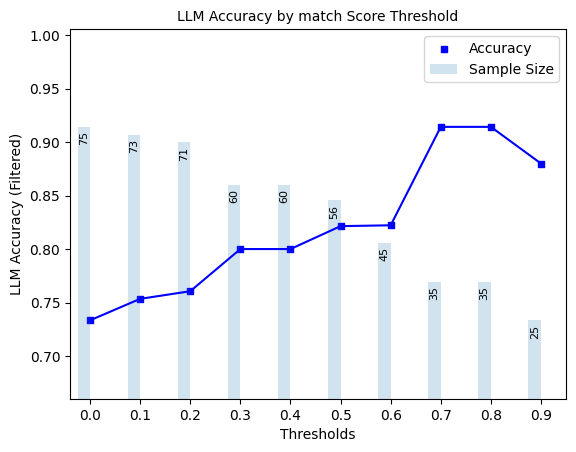

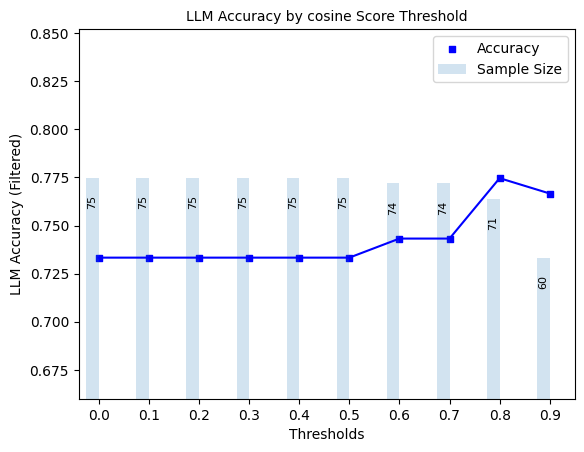

In [23]:
for scorer in ["entropy", "match", "cosine"]:
    confidence_score = f"{scorer}_score"
    plot_model_accuracies(
        scores=result_df[confidence_score],
        correct_indicators=result_df.response_correct,
        title=f"LLM Accuracy by {scorer} Score Threshold",
    )

Lastly, we will compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we can compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [24]:
# instantiate UQLM tuner object for threshold selection
t = Tuner()

correct_indicators = (
    result_df.response_correct
) * 1  # Whether responses is actually correct
for scorer in ["entropy", "match", "cosine"]:
    confidence_score = f"{scorer}_score"
    y_scores = result_df[confidence_score]  # confidence score

    # Solve for threshold that maximizes F1-score
    best_threshold = t.tune_threshold(
        y_scores=y_scores,
        correct_indicators=correct_indicators,
        thresh_objective="fbeta_score",
    )
    y_pred = [
        (s > best_threshold) * 1 for s in y_scores
    ]  # predicts whether response is correct based on confidence score
    print(f"{scorer} score F1-optimal threshold: {best_threshold}")
    print(" ")

    # evaluate precision, recall, and f1-score of predictions of correctness
    print(
        f"{scorer} score precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}"
    )
    print(
        f"{scorer} score recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}"
    )
    print(
        f"{scorer} score f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}"
    )
    print(" ")
    print(" ")

entropy score F1-optimal threshold: 0.22
 
entropy score precision: 0.7971014492753623
entropy score recall: 1.0
entropy score f1-score: 0.8870967741935484
 
 
match score F1-optimal threshold: 0.0
 
match score precision: 0.7534246575342466
match score recall: 1.0
match score f1-score: 0.859375
 
 
cosine score F1-optimal threshold: 0.8
 
cosine score precision: 0.7746478873239436
cosine score recall: 1.0
cosine score f1-score: 0.873015873015873
 
 
